In [7]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

luna_path = "D:\\Data\\LUNA16\\"
luna_subset_path = luna_path + "subset0"
file_list=glob(luna_subset_path+"\\*.mhd")
print(file_list[0])
output_path = "D:\\Data\\LUNA16\\NODULE_SLICE_DATA\\"

print("success")

D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
success


In [8]:
#####################
# Some helper functions
def make_mask(center, diam, z, width, height, spacing, origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width])  # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center - origin) / spacing
    v_diam = int(diam / spacing[0] + 5)
    v_xmin = np.max([0, int(v_center[0] - v_diam) - 5])
    v_xmax = np.min([width - 1, int(v_center[0] + v_diam) + 5])
    v_ymin = np.max([0, int(v_center[1] - v_diam) - 5])
    v_ymax = np.min([height - 1, int(v_center[1] + v_diam) + 5])

    v_xrange = range(v_xmin, v_xmax + 1)
    v_yrange = range(v_ymin, v_ymax + 1)

    # Convert back to world coordinates for distance calculation
    x_data = [x * spacing[0] + origin[0] for x in range(width)]
    y_data = [x * spacing[1] + origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0] * v_x + origin[0]
            p_y = spacing[1] * v_y + origin[1]
            if np.linalg.norm(center - np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y - origin[1]) / spacing[1]), int((p_x - origin[0]) / spacing[0])] = 1.0
    return (mask)

def matrix2int16(matrix):
    ''' 
        matrix must be a numpy array NXN
        Returns uint16 version
    '''
    m_min = np.min(matrix)
    m_max = np.max(matrix)
    matrix = matrix - m_min
    return (np.array(np.rint((matrix - m_min) / float(m_max - m_min) * 65535.0), dtype=np.uint16))
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    for f in file_list:
        if case in f:
            return(f)

In [9]:
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)

df_node = df_node.dropna()
print(df_node.head())


                                            seriesuid      coordX      coordY  \
23  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   67.260517   
25  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   48.402806   
26  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   76.771663   
28  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059  117.765579   
86  1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  145.967465 -161.197634   

        coordZ  diameter_mm                                               file  
23 -231.816619     6.440879  D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1...  
25 -108.578632    13.596471  D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1...  
26 -123.321911     4.343200  D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1...  
28 -181.947817     4.681382  D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1...  
86 -312.071347     6.378436  D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1...  


In [10]:
#####
#
# Looping over the image files
#
fcount = 0
print(len(file_list))
for img_file in file_list:
    print('=========================')
    print(fcount)
    if fcount > 3:
        break
    print(img_file)
    print ("Getting mask for image file %s" % img_file.replace(luna_subset_path,""))

    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:       # some files may not have a nodule--skipping those 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape 
        # just keep 3 slices
        imgs = np.ndarray([3, height, width], dtype=np.float32)
        masks = np.ndarray([3, height, width], dtype=np.uint8)
        center = np.array([node_x,node_y,node_z])   # nodule center
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
        i = 0
        for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
            mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
            masks[i] = mask
            imgs[i] = matrix2int16(img_array[i_z])
            i+=1
        np.save(output_path+"images_%d.npy" % (fcount) ,imgs)
        print ("Getting mask for image file %s" % (output_path+"images_%d.npy"))
        print ("Getting mask for image file %s" % img_file.replace(luna_subset_path,""))
        np.save(output_path+"masks_%d.npy" % (fcount) ,masks)
        print ("Getting mask for image file %s" % (output_path+"masks_%d.npy"))
        fcount += 1
print("DONE!!!")

89
0
D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Getting mask for image file \1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
0
D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Getting mask for image file \1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Getting mask for image file D:\Data\LUNA16\NODULE_SLICE_DATA\images_%d.npy
Getting mask for image file \1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Getting mask for image file D:\Data\LUNA16\NODULE_SLICE_DATA\masks_%d.npy
1
D:\Data\LUNA16\subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Getting mask for image file \1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Getting mask for image file D:\Data\LUNA16\NODULE_SLICE_DATA\images_%d.npy
Getting mask for image file \1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
G

3
image 0
(512, 512)


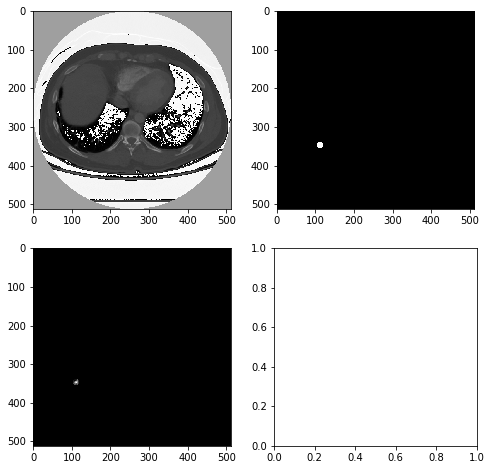

image 1
(512, 512)


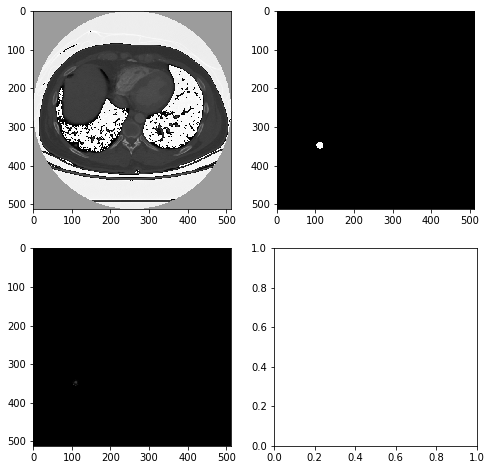

image 2
(512, 512)


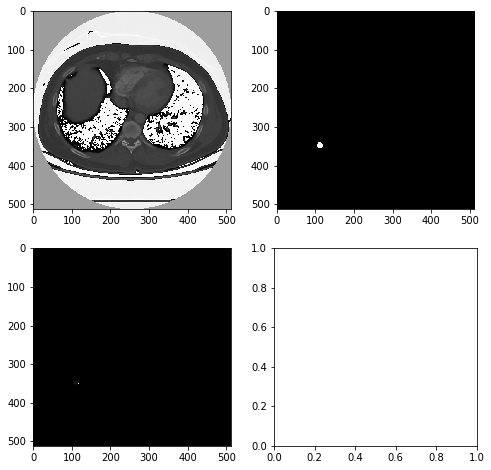

In [11]:
import matplotlib.pyplot as plt
imgs = np.load(output_path+'images_0.npy')
masks = np.load(output_path+'masks_0.npy')
print(len(imgs))
for i in range(len(imgs)):
    print ("image %d" % i)
    print(imgs[i].shape)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
#     raw_input("hit enter to cont : ")